In [1]:
import sympy as sp
import control as ct
import matplotlib.pyplot as plt
import numpy as np

plt.style.use('../maroon_ipynb.mplstyle')

From lecture 17, we are finding the frequency response of the two mass suspension model whose equations are

In [2]:
m1, m2, k1, k2, c1, s, t = sp.symbols('m1:3 k1:3 c1 s t')
x1, x2, y = sp.Function('x1')(t), sp.Function('x2')(t), sp.Function('y')(t)

m1_, m2_ = 250, 25
k1_, k2_ = 1.0975e4, 1e5
c1_ = 943

eq1 = sp.Eq(m1*x1.diff(t, 2), k1*(x2 - x1) + c1*(x2.diff() - x1.diff()))
eq2 = sp.Eq(m2*x2.diff(t, 2), k2*(y - x2) + k1*(x1 - x2) + c1*(x1.diff() - x2.diff()))
display(eq1, eq2)

Eq(m1*Derivative(x1(t), (t, 2)), c1*(-Derivative(x1(t), t) + Derivative(x2(t), t)) + k1*(-x1(t) + x2(t)))

Eq(m2*Derivative(x2(t), (t, 2)), c1*(Derivative(x1(t), t) - Derivative(x2(t), t)) + k1*(x1(t) - x2(t)) + k2*(-x2(t) + y(t)))

In [3]:
lp = lambda expr: sp.laplace_transform(expr, t, s)[0]

eq1_s = sp.Eq(lp(eq1.lhs), lp(eq1.rhs.expand()))
eq2_s = sp.Eq(lp(eq2.lhs), lp(eq2.rhs.expand()))

sub_ics = [
    (x1.subs(t, 0), 0),
    (x2.subs(t, 0), 0),
    (x1.diff().subs(t, 0), 0),
    (x2.diff().subs(t, 0), 0)
]

eq1_s = eq1_s.subs(sub_ics)
eq2_s = eq2_s.subs(sub_ics)

sol_lp = sp.solve([eq1_s, eq2_s], [lp(x1), lp(x2)])
for key, value in sol_lp.items():
    T = (value/lp(y)).simplify()
    display(sp.Eq(key/lp(y), T.collect(s)))

Eq(LaplaceTransform(x1(t), t, s)/LaplaceTransform(y(t), t, s), k2*(c1*s + k1)/(c1*k2*s + k1*k2 + m1*m2*s**4 + s**3*(c1*m1 + c1*m2) + s**2*(k1*m1 + k1*m2 + k2*m1)))

Eq(LaplaceTransform(x2(t), t, s)/LaplaceTransform(y(t), t, s), k2*(c1*s + k1 + m1*s**2)/(c1*k2*s + k1*k2 + m1*m2*s**4 + s**3*(c1*m1 + c1*m2) + s**2*(k1*m1 + k1*m2 + k2*m1)))

In [4]:
den = [m1_*m2_, c1_*m1_ + c1_*m2_, k1_*m1_ + k1_*m2_ + k2_*m1_, c1_*k2_, k1_*k2_]

T1 = ct.tf([c1_*k2_, k2_*k1_], den)
T2 = ct.tf([k2_*m1_, k2_*c1_, k2_*k1_], den)

display(T1, T2)

TransferFunction(array([9.4300e+07, 1.0975e+09]), array([6.2500000e+03, 2.5932500e+05, 2.8018125e+07, 9.4300000e+07,
       1.0975000e+09]))

TransferFunction(array([2.5000e+07, 9.4300e+07, 1.0975e+09]), array([6.2500000e+03, 2.5932500e+05, 2.8018125e+07, 9.4300000e+07,
       1.0975000e+09]))

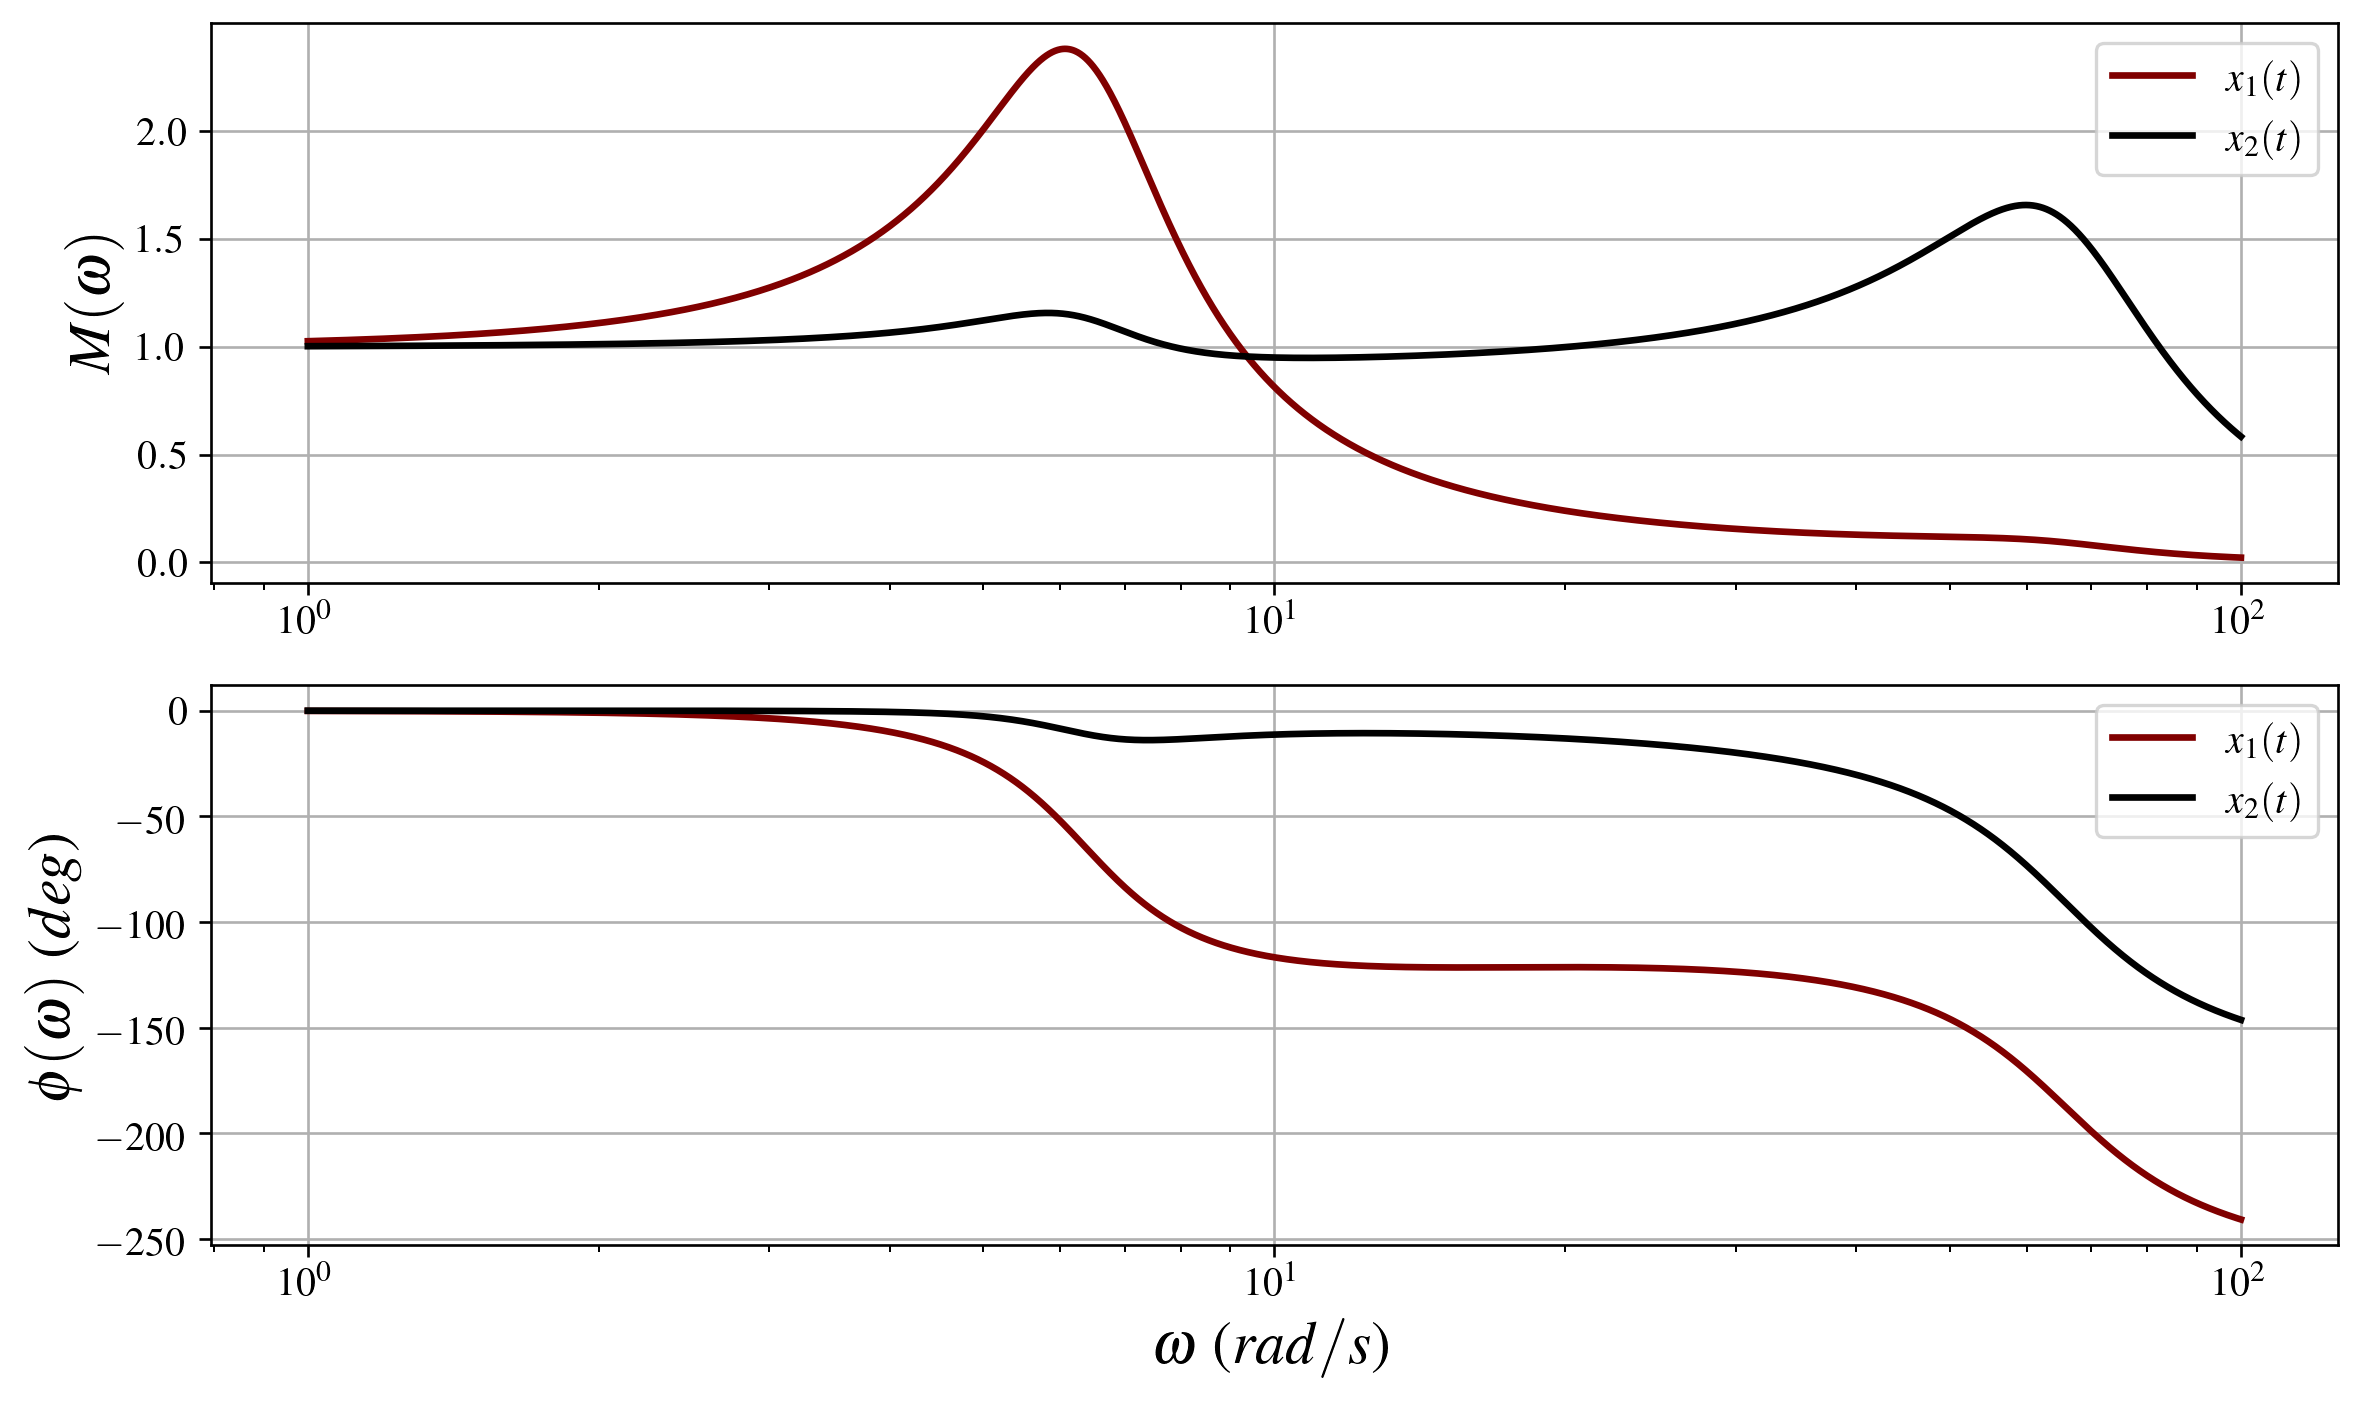

In [5]:
# Getting the frequency response
omegas = np.linspace(1, 100, 10_000)
mag1, phase1, _ = ct.frequency_response(T1, omegas)
mag2, phase2, _ = ct.frequency_response(T2, omegas)

# The phase output does not go more negative than 180 for the above function, so we need to fix that here
phase1[phase1 > 0] = phase1[phase1 > 0] - 2*np.pi

fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1)
ax1.set_xscale('log')
ax2.set_xscale('log')

ax1.plot(omegas, mag1, label='$x_1(t)$')
ax1.plot(omegas, mag2, label='$x_2(t)$')
ax2.plot(omegas, np.rad2deg(phase1), label='$x_1(t)$')
ax2.plot(omegas, np.rad2deg(phase2), label='$x_2(t)$')

ax1.set_ylabel(r'$M(\omega)$')
ax2.set_ylabel(r'$\phi(\omega)$ ($deg$)')
ax2.set_xlabel(r'$\omega$ ($rad/s$)')
ax1.legend()
ax2.legend()
plt.show()

In [6]:
tire_max = omegas[max(mag2) == mag2][0]
tire_max  # Maximum frequency in rad/s for tire displacement

59.89108910891089

In [7]:
chassis_max = omegas[max(mag1) == mag1][0]
chassis_max  # Maximum frequency in rad/s for the chassis displacement

6.069306930693069

From the above results, we can see that the chassis is not affected by high frequencies. The tires, however, are affected by frequencies around 60 rad/s. This would be a good frequency for rumble strips. Furthermore, the chassis experiences a maximum displacement of 2.38 times the bump amplitude for frequencies around 6 rad/s.